# Question 4: Transfer Learning
- Basing on your dataset in Q3_CNN, choose a suitable pre-trained model (VGG16, Resnet50, InceptionV3, MobileNet....) and a strategy to build a model to classify class of each sample.
- Compare execution time and accuracy of two models (Q3 3 vs. Q4)

# 0. Mount drive & import packages

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/My Drive/LDS8_K270_ONLINE_DamThiMinhPhuong/LDS8_K270_DamThiMinhPhuong_Cuoi_ky/Question4_TransferLearning'

/content/gdrive/My Drive/LDS8_K270_ONLINE_DamThiMinhPhuong/LDS8_K270_DamThiMinhPhuong_Cuoi_ky/Question4_TransferLearning


In [ ]:
from tensorflow.keras.applications import vgg16, inception_v3, resnet50, mobilenet
from tensorflow.keras.models import load_model

from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential, Model 
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as k 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [ ]:
!pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=17798011aae381c8d195d87e2bbc87f369f2f4262914462cbee5179050305342
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
from Lib_ import *
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from Lib_.ipynb


# 1. Download and save pretrained model

In [ ]:
#Load pre_trained model: VGG model, Inception_V3 model, ResNet50 model, MobileNet model
vgg_model = vgg16.VGG16(weights='imagenet')
inception_model = inception_v3.InceptionV3(weights='imagenet')
resnet_model = resnet50.ResNet50(weights='imagenet')
mobilenet_model = mobilenet.MobileNet(weights='imagenet')

In [ ]:
#Save models to local computer
vgg_model.save('vgg_model.h5')
inception_model.save('inception_model.h5')
resnet_model.save('resnet_model.h5')
mobilenet_model.save('mobilenet_model.h5')

# 2. Load models and pre-processing an image

In [ ]:
#Load these models
vgg_model = load_model('vgg_model.h5')
inception_model = load_model('inception_model.h5')
resnet_model = load_model('resnet_model.h5')
mobilenet_model = load_model('mobilenet_model.h5')

PIL image size (224, 224)
numpy array size (224, 224, 3)
image batch size (1, 224, 224, 3)
VGG model label [[('n03916031', 'perfume', 0.1665301), ('n03690938', 'lotion', 0.1384796), ('n04357314', 'sunscreen', 0.11415115), ('n03843555', 'oil_filter', 0.052736666), ('n03871628', 'packet', 0.04447378)]]
Intercept_V3 model label [[('n03063599', 'coffee_mug', 0.22817795), ('n03843555', 'oil_filter', 0.18254611), ('n03690938', 'lotion', 0.10294516), ('n04357314', 'sunscreen', 0.058056667), ('n04557648', 'water_bottle', 0.053291675)]]
resnet50 model label [[('n03690938', 'lotion', 0.3076305), ('n03843555', 'oil_filter', 0.26995224), ('n03887697', 'paper_towel', 0.12693898), ('n04357314', 'sunscreen', 0.04302413), ('n07932039', 'eggnog', 0.036019422)]]
mobilenet model label [[('n03843555', 'oil_filter', 0.69203836), ('n03690938', 'lotion', 0.18765405), ('n04357314', 'sunscreen', 0.032936648), ('n03476991', 'hair_spray', 0.02488943), ('n03916031', 'perfume', 0.009332664)]]


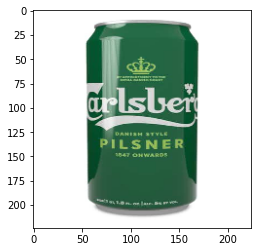

In [ ]:
pre_train_model_check('dataset/can.jpg',vgg_model,inception_model,resnet_model,mobilenet_model)

PIL image size (224, 224)
numpy array size (224, 224, 3)
image batch size (1, 224, 224, 3)
VGG model label [[('n04557648', 'water_bottle', 0.88999283), ('n03825788', 'nipple', 0.091655254), ('n04560804', 'water_jug', 0.014877123), ('n04254120', 'soap_dispenser', 0.0005054651), ('n03983396', 'pop_bottle', 0.00039977723)]]
Intercept_V3 model label [[('n04557648', 'water_bottle', 0.99567974), ('n04560804', 'water_jug', 0.0020082537), ('n03825788', 'nipple', 0.00047495897), ('n03188531', 'diaper', 0.00014378606), ('n03983396', 'pop_bottle', 0.00010884949)]]
resnet50 model label [[('n04557648', 'water_bottle', 0.9998128), ('n04560804', 'water_jug', 0.0001431068), ('n03825788', 'nipple', 3.5268753e-05), ('n04254120', 'soap_dispenser', 4.1014523e-06), ('n03937543', 'pill_bottle', 6.596596e-07)]]
mobilenet model label [[('n04557648', 'water_bottle', 0.99007004), ('n03825788', 'nipple', 0.005831678), ('n04560804', 'water_jug', 0.0022093807), ('n03983396', 'pop_bottle', 0.0013908673), ('n0393754

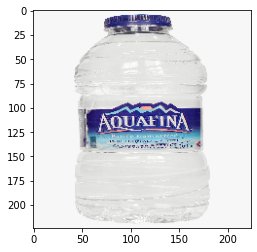

In [ ]:
pre_train_model_check('dataset/bottle.png',vgg_model,inception_model,resnet_model,mobilenet_model)

### Nhận xét:
- Cả 4 pre-trained model đều không nhận diện được lon nước (can) nhưng nhận diện tốt chai nước (water bottle) đặc biệt là resnet50 cho kết quả gần như tuyệt đối: 0.9998128
- => dataset nhỏ và khác với dataset của pre-trained model => Lựa chọn strategy 2: Đóng băng 1 số layer và train phần còn lại

# 3. Train model using strategy 2

### 3.1 Resnet50: image(224,224)

In [ ]:
img_width, img_height = 224, 224
train_data_dir = "../Question3_CNN/new_dataset2/train"   
validation_data_dir = "../Question3_CNN/new_dataset2/test"  

In [ ]:
# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   fill_mode = "nearest",
                                   zoom_range = 0.3,
                                   width_shift_range = 0.3,
                                   height_shift_range=0.3,
                                   rotation_range=30)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size = (img_height, 
                                                                   img_width),
                                                    batch_size = 32, 
                                                    class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                    target_size = (img_height, 
                                                                   img_width),
                                                    class_mode = "categorical")

Found 6937 images belonging to 2 classes.
Found 1401 images belonging to 2 classes.


In [ ]:
model1 = applications.resnet50.ResNet50(weights='imagenet',
                           include_top=False, #whether to include the 3 fully connected layers at the top of the network
                            input_shape=(img_width, img_height,3))

94781440/94765736 [==============================] - 2s 0us/step


In [ ]:
model1.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
#So lets freeze all the Resnet layers and train only the classifier
# for layer in model.layers:
#   layer.trainable = False
for layer in model1.layers[:6]:    #chỉ đóng băng 6 layers đầu
  layer.trainable = False

In [ ]:
#Adding custom layers - ANN
x = model1.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='sigmoid')(x)
#dung softmax neu co tu 3 class tro len

In [ ]:
#creating the final model
model1_final = Model(inputs=model1.input, outputs=predictions)

In [ ]:
#compile the model
model1_final.compile(loss='binary_crossentropy',
                    optimizer = 'adam',
                    metrics=['accuracy'])

In [ ]:
# Save the model according to the conditions  
checkpoint1 = ModelCheckpoint("can_bottle_resnet50_cp.h5", 
                             monitor='val_loss', 
                            #  verbose=0, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq='epoch')
early1 = EarlyStopping(monitor='val_loss', 
                      min_delta=0.001, 
                      patience=10, 
                      # verbose=0, 
                      mode='auto')

In [ ]:
import datetime

In [ ]:
t0 = datetime.datetime.now()

In [ ]:
history = model1_final.fit(train_generator,
                          batch_size = 32,
                          epochs = 20,
                          validation_data = validation_generator,                    
                          verbose=1,
                          callbacks=[checkpoint1, early1]
                          )

Epoch 1/20
217/217 [==============================] - 4637s 21s/step - loss: 1.0924 - accuracy: 0.7115 - val_loss: 2.0603 - val_accuracy: 0.5004
Epoch 2/20
217/217 [==============================] - 264s 1s/step - loss: 0.5702 - accuracy: 0.7608 - val_loss: 1.0069 - val_accuracy: 0.5004
Epoch 3/20
217/217 [==============================] - 271s 1s/step - loss: 0.4549 - accuracy: 0.8002 - val_loss: 0.7688 - val_accuracy: 0.4996
Epoch 4/20
217/217 [==============================] - 250s 1s/step - loss: 0.4460 - accuracy: 0.8054 - val_loss: 194.4310 - val_accuracy: 0.4996
Epoch 5/20
217/217 [==============================] - 228s 1s/step - loss: 0.4106 - accuracy: 0.8214 - val_loss: 7793.4077 - val_accuracy: 0.4996
Epoch 6/20
217/217 [==============================] - 227s 1s/step - loss: 0.3817 - accuracy: 0.8331 - val_loss: 39.3614 - val_accuracy: 0.4996
Epoch 7/20
217/217 [==============================] - 227s 1s/step - loss: 0.3426 - accuracy: 0.8541 - val_loss: 2.6172 - val_accuracy

In [ ]:
t1 = datetime.datetime.now()
duration_1 = t1-t0
print('Duration:', duration_1)

Duration: 2:05:45.101903


In [ ]:
history_df1 = pd.DataFrame(history.history)
history_df1.tail()

,loss,accuracy,val_loss,val_accuracy
8,0.388390,0.836961,62.430946,0.499643
9,0.423897,0.826870,3030.194824,0.499643
10,0.358835,0.847773,49.169884,0.499643
11,0.316518,0.866945,37.679264,0.499643
12,0.292318,0.879775,0.843509,0.499643


In [ ]:
# Evaluation on train & test
result1_train = model1_final.evaluate(train_generator)
result1_val = model1_final.evaluate(validation_generator)
result1_df = pd.DataFrame([result1_train[0],result1_train[1],result1_val[0],result1_val[1]], 
                            index=['loss','accuracy', 'val_loss','val_accuracy'], 
                           columns=['model1_Resnet50'])
result1_df = result1_df.T
result1_df

44/44 [==============================] - 17s 395ms/step - loss: 0.8435 - accuracy: 0.4996


,loss,accuracy,val_loss,val_accuracy
model1_Resnet50,0.753928,0.568113,0.843509,0.499643


In [ ]:
#save model
model1_final.save('can_bottle_restnet50.h5')
print('Saved!!')

Saved!!


### Nhận xét:     
- Có thể thấy Mô hình Resnet50 (strategy 2) đem lại kết quả underfitting

### 3.2 MobiNet: image(224,224)

In [ ]:
model2 = applications.MobileNet(weights='imagenet',
                           include_top=False, #whether to include the 3 fully connected layers at the top of the network
                            input_shape=(img_width, img_height,3))

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
model2.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [ ]:
#So lets freeze all the Resnet layers and train only the classifier
# for layer in model.layers:
#   layer.trainable = False
for layer in model2.layers[:8]:    #chỉ đóng băng 8 layers đầu
  layer.trainable = False

In [ ]:
#Adding custom layers - ANN
x = model2.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='sigmoid')(x)
#dung softmax neu co tu 3 class tro len

In [ ]:
#creating the final model
model2_final = Model(inputs=model2.input, outputs=predictions)


In [ ]:
#compile the model
model2_final.compile(loss='binary_crossentropy',
                    optimizer = 'adam',
                    metrics=['accuracy'])

In [ ]:
# Save the model according to the conditions  
checkpoint2 = ModelCheckpoint("can_bottle_mobilenet_cp.h5", 
                             monitor='val_loss', 
                            #  verbose=0, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq='epoch')
early2 = EarlyStopping(monitor='val_loss', 
                      min_delta=0.001, 
                      patience=10, 
                      # verbose=0, 
                      mode='auto')

In [ ]:
import datetime
t0 = datetime.datetime.now()

In [ ]:
history2 = model2_final.fit(train_generator,
                          batch_size = 32,
                          epochs = 20,
                          validation_data = validation_generator,                    
                          verbose=1,
                          callbacks=[checkpoint2, early2]
                          )

Epoch 1/20
217/217 [==============================] - 282s 1s/step - loss: 0.2468 - accuracy: 0.9181 - val_loss: 0.8642 - val_accuracy: 0.8351
Epoch 2/20
217/217 [==============================] - 280s 1s/step - loss: 0.1781 - accuracy: 0.9410 - val_loss: 0.0867 - val_accuracy: 0.9665
Epoch 3/20
217/217 [==============================] - 288s 1s/step - loss: 0.1444 - accuracy: 0.9503 - val_loss: 0.2021 - val_accuracy: 0.9529
Epoch 4/20
217/217 [==============================] - 306s 1s/step - loss: 0.1295 - accuracy: 0.9542 - val_loss: 0.0977 - val_accuracy: 0.9657
Epoch 5/20
217/217 [==============================] - 302s 1s/step - loss: 0.1276 - accuracy: 0.9595 - val_loss: 0.2098 - val_accuracy: 0.9408
Epoch 6/20
217/217 [==============================] - 304s 1s/step - loss: 0.1278 - accuracy: 0.9543 - val_loss: 0.1022 - val_accuracy: 0.9686
Epoch 7/20
217/217 [==============================] - 287s 1s/step - loss: 0.1153 - accuracy: 0.9565 - val_loss: 0.2158 - val_accuracy: 0.9600

In [ ]:
t1 = datetime.datetime.now()
print('Duration:',t1-t0)

Duration: 1:16:57.850142


In [ ]:
import pandas as pd
history_df2 = pd.DataFrame(history2.history)
history_df2.tail()

,loss,accuracy,val_loss,val_accuracy
7,0.124481,0.959204,0.214701,0.949322
8,0.100542,0.964682,0.100825,0.975732
9,0.124184,0.956754,0.639074,0.883655
10,0.124659,0.960790,0.595576,0.822984
11,0.112504,0.961367,0.263030,0.943612


In [ ]:
#save model
from tensorflow.keras.models import load_model
model2_final.save('can_bottle_mobilenet.h5')
print('Saved!!')

Saved!!


In [ ]:
# Em quên chưa tính Evaluate nên em load model vô để tính ạ!
from tensorflow.keras.models import load_model
model_mobilenet = load_model('can_bottle_mobilenet.h5')

In [ ]:
# Evaluation on train & test
result2_train = model_mobilenet.evaluate(train_generator)
result2_val = model_mobilenet.evaluate(validation_generator)
result2_df = pd.DataFrame([result2_train[0],result2_train[1],result2_val[0],result2_val[1]], 
                            index=['loss','accuracy', 'val_loss','val_accuracy'], 
                           columns=['model2_Mobilenet'])
result2_df = result2_df.T
result2_df

44/44 [==============================] - 16s 366ms/step - loss: 0.2630 - accuracy: 0.9436


,loss,accuracy,val_loss,val_accuracy
model2_Mobilenet,0.160293,0.94623,0.26303,0.943612


### Nhận xét:    
- Mô hình Mobilenet (Strategy 2) cho kết quả rất tốt trên tập train và test (accuracy ~94%) => Mô hình phù hợp với dữ liệu 
- Thời gian train tương đối ngắn so với Resnet50


### 3.3 VGG16 - image(224,224)

In [ ]:
model3 = applications.vgg16.VGG16(weights='imagenet',
                           include_top=False, #whether to include the 3 fully connected layers at the top of the network
                            input_shape=(img_width, img_height,3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model3.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#So lets freeze all the Resnet layers and train only the classifier
# for layer in model.layers:
#   layer.trainable = False
for layer in model3.layers[:7]:    #chỉ đóng băng 7 layers đầu
  layer.trainable = False

In [ ]:
#Adding custom layers - ANN
x = model3.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='sigmoid')(x)
#dung softmax neu co tu 3 class tro len

In [ ]:
#creating the final model
model3_final = Model(inputs=model3.input, outputs=predictions)

In [ ]:
#compile the model
model3_final.compile(loss='binary_crossentropy',
                    optimizer = 'adam',
                    metrics=['accuracy'])

In [ ]:
# Save the model according to the conditions  
checkpoint3 = ModelCheckpoint("can_bottle_vgg16_cp.h5", 
                             monitor='val_loss', 
                            #  verbose=0, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq='epoch')
early3 = EarlyStopping(monitor='val_loss', 
                      min_delta=0.001, 
                      patience=10, 
                      # verbose=0, 
                      mode='auto')

In [ ]:
t0 = datetime.datetime.now()

In [ ]:
history3 = model3_final.fit(train_generator,
                          batch_size = 32,
                          epochs = 20,
                          validation_data = validation_generator,                    
                          verbose=1,
                          callbacks=[checkpoint3, early3]
                          )

Epoch 1/20
217/217 [==============================] - 240s 1s/step - loss: 0.7249 - accuracy: 0.5561 - val_loss: 0.7462 - val_accuracy: 0.4354
Epoch 2/20
217/217 [==============================] - 225s 1s/step - loss: 0.7165 - accuracy: 0.5641 - val_loss: 0.7074 - val_accuracy: 0.4996
Epoch 3/20
217/217 [==============================] - 216s 995ms/step - loss: 0.6843 - accuracy: 0.5681 - val_loss: 0.7094 - val_accuracy: 0.4996
Epoch 4/20
217/217 [==============================] - 219s 1s/step - loss: 0.6844 - accuracy: 0.5681 - val_loss: 0.7008 - val_accuracy: 0.4996
Epoch 5/20
217/217 [==============================] - 222s 1s/step - loss: 0.6842 - accuracy: 0.5681 - val_loss: 0.7002 - val_accuracy: 0.4996
Epoch 6/20
217/217 [==============================] - 211s 973ms/step - loss: 0.6841 - accuracy: 0.5681 - val_loss: 0.7072 - val_accuracy: 0.4996
Epoch 7/20
217/217 [==============================] - 213s 983ms/step - loss: 0.6840 - accuracy: 0.5681 - val_loss: 0.7043 - val_accurac

In [ ]:
t1 = datetime.datetime.now()
duration_3 = t1-t0
print('Duration:',duration_3)

Duration: 1:14:09.202121


In [ ]:
history_df3 = pd.DataFrame(history3.history)
history_df3.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.683851,0.568113,0.704558,0.499643
16,0.684174,0.568113,0.704535,0.499643
17,0.684055,0.568113,0.701912,0.499643
18,0.683938,0.568113,0.704376,0.499643
19,0.684272,0.568113,0.702950,0.499643


In [ ]:
# Evaluation on train & test
result3_train = model3_final.evaluate(train_generator)
result3_val = model3_final.evaluate(validation_generator)
result3_df = pd.DataFrame([result3_train[0],result3_train[1],result3_val[0],result3_val[1]], 
                            index=['loss','accuracy', 'val_loss','val_accuracy'], 
                           columns=['model3_vgg16'])
result3_df = result3_df.T
result3_df

44/44 [==============================] - 17s 370ms/step - loss: 0.7029 - accuracy: 0.4996


,loss,accuracy,val_loss,val_accuracy
model3_vgg16,0.683843,0.568113,0.70295,0.499643


In [ ]:
#save model
model3_final.save('can_bottle_vgg16.h5')
print('Saved!!')

Saved!!


### Nhận xét:     
- Có thể nhận thấy pre-trained model VGG16 (strategy 2) có hiện tượng underfitting 

### 3.4 Inception_v3 - image(299,299)

In [ ]:
img_width2, img_height2 = 299, 299
train_data_dir = "../Question3_CNN/new_dataset2/train"   
validation_data_dir = "../Question3_CNN/new_dataset2/test"  

In [ ]:
# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   fill_mode = "nearest",
                                   zoom_range = 0.3,
                                   width_shift_range = 0.3,
                                   height_shift_range=0.3,
                                   rotation_range=30)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator2 = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size = (img_height2, 
                                                                   img_width2),
                                                    batch_size = 32, 
                                                    class_mode = "categorical")

validation_generator2 = test_datagen.flow_from_directory(validation_data_dir,
                                                    target_size = (img_height2, 
                                                                   img_width2),
                                                    class_mode = "categorical")

Found 6937 images belonging to 2 classes.
Found 1401 images belonging to 2 classes.


In [ ]:
model4 = applications.inception_v3.InceptionV3(weights='imagenet',
                           include_top=False, #whether to include the 3 fully connected layers at the top of the network
                            input_shape=(img_width2, img_height2,3))

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
model4.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
#So lets freeze all the Resnet layers and train only the classifier
# for layer in model.layers:
#   layer.trainable = False
for layer in model4.layers[:11]:    #chỉ đóng băng 11 layers đầu
  layer.trainable = False

In [ ]:
#Adding custom layers - ANN
x = model4.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='sigmoid')(x)

In [ ]:
#creating the final model
model4_final = Model(inputs=model4.input, outputs=predictions)
#compile the model
model4_final.compile(loss='binary_crossentropy',
                    optimizer = 'adam',
                    metrics=['accuracy'])

In [ ]:
# Save the model according to the conditions  
checkpoint4 = ModelCheckpoint("can_bottle_inceptionV3_cp.h5", 
                             monitor='val_loss', 
                            #  verbose=0, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq='epoch')
early4 = EarlyStopping(monitor='val_loss', 
                      min_delta=0.001, 
                      patience=10, 
                      # verbose=0, 
                      mode='auto')

In [ ]:
import datetime
t0 = datetime.datetime.now()

In [ ]:
history4 = model4_final.fit(train_generator2,
                          batch_size = 32,
                          epochs = 20,
                          validation_data = validation_generator2,                    
                          verbose=1,
                          callbacks=[checkpoint4, early4]
                          )

Epoch 1/20
217/217 [==============================] - 2523s 11s/step - loss: 1.4822 - accuracy: 0.5488 - val_loss: 1.1850 - val_accuracy: 0.4996
Epoch 2/20
217/217 [==============================] - 413s 2s/step - loss: 0.6909 - accuracy: 0.5621 - val_loss: 0.6863 - val_accuracy: 0.4996
Epoch 3/20
217/217 [==============================] - 372s 2s/step - loss: 0.6856 - accuracy: 0.5668 - val_loss: 0.7023 - val_accuracy: 0.4996
Epoch 4/20
217/217 [==============================] - 342s 2s/step - loss: 0.6955 - accuracy: 0.5856 - val_loss: 0.7748 - val_accuracy: 0.7195
Epoch 5/20
217/217 [==============================] - 340s 2s/step - loss: 0.8709 - accuracy: 0.5994 - val_loss: 0.8978 - val_accuracy: 0.6081
Epoch 6/20
217/217 [==============================] - 338s 2s/step - loss: 0.6879 - accuracy: 0.5701 - val_loss: 0.7278 - val_accuracy: 0.5068
Epoch 7/20
217/217 [==============================] - 336s 2s/step - loss: 0.6853 - accuracy: 0.5726 - val_loss: 0.7010 - val_accuracy: 0.53

In [ ]:
t1 = datetime.datetime.now()
print('Duration:',t1-t0)

Duration: 2:37:41.415156


In [ ]:
history_df4 = pd.DataFrame(history4.history)
history_df4.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.346415,0.872567,0.425227,0.820129
16,0.315863,0.876171,0.345588,0.832976
17,0.284728,0.893758,0.316083,0.868665
18,0.268353,0.896353,0.282667,0.900071
19,0.265062,0.898083,0.417528,0.843683


In [ ]:
inceptionv3_model = load_model('can_bottle_interceptionV3.h5')

In [ ]:
# Evaluation on train & test
result4_train = inceptionv3_model.evaluate(train_generator2)
result4_val = inceptionv3_model.evaluate(validation_generator2)
result4_df = pd.DataFrame([result4_train[0],result4_train[1],result4_val[0],result4_val[1]], 
                            index=['loss','accuracy', 'val_loss','val_accuracy'], 
                           columns=['model4_Inception_V3'])
result4_df = result4_df.T
result4_df

44/44 [==============================] - 18s 416ms/step - loss: 0.4175 - accuracy: 0.8437


,loss,accuracy,val_loss,val_accuracy
model4_Inception_V3,0.510113,0.787516,0.417528,0.843683


In [ ]:
#save model
model4_final.save('can_bottle_interceptionV3.h5')
print('Saved!!')

Saved!!


# 4. Kết luận

In [ ]:
final_result = pd.concat([result1_df, result2_df, result3_df, result4_df])
final_result

,loss,accuracy,val_loss,val_accuracy
model1_Resnet50,0.753928,0.568113,0.843509,0.499643
model2_Mobilenet,0.160293,0.946230,0.263030,0.943612
model3_vgg16,0.683843,0.568113,0.702950,0.499643
model4_Inception_V3,0.510113,0.787516,0.417528,0.843683


### Nhận xét:    
- Kết quả của 4 pre-trained model
  + Resnet50: overfitting
  + VGG16: underfitting
  + Inception_V3: underfitting
  + Mobilenet: phù hợp dữ liệu (accr train và test ~94%)
- Kết quả trên model Mobilenet so với kết quả của câu 3 (accr train: 97%, accr test 92%): model Mobilenet cho kết quả ổn hơn khi train và test xấp xỉ nhau 94%. Trong khi model ở câu 3 có hiện tượng overfitting nhẹ tuy là chấp nhận được.
- Thời gian train câu 3 là 2h36', trong khi mobilenet là 1h16ph, chỉ bằng 1/2
-=> mô hình pre-trained Mobilenet là lựa chọn tốt hơn đối với tập dữ liệu này! 